In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.simple import CharTokenizer
from tqdm import tqdm_notebook as tqdm
import pickle
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# nltk.download('punkt')
# nltk.download('wordnet')

In [3]:
lemmatizer = WordNetLemmatizer()
char = CharTokenizer()
unique_characters = 'abcdefghijklmnopqrstuvwxyz 01234567890!@#$%&*()'

def process_review(review):
    
    review = word_tokenize(review)
    review = [lemmatizer.lemmatize(word) for word in review]
    review = [word.lower() for word in review]
    review = " ".join(str(word) for word in review)
    review = char.tokenize(review)
    keep = [char for char in unique_characters]
    review = [char for char in review if char in keep]
    
    return review
    
    
DF = pd.DataFrame(columns=['text', 'target', 'predict'])

for name in ['amazon_cells_labelled', 'imdb_labelled', 'yelp_labelled']:
    file = name + '.txt'
    df = pd.read_csv(file, names=['text', 'target'], sep='\t')
    DF = DF.append(df, ignore_index=True, sort=False)
    
DF.text = DF.text.apply(lambda x : process_review(x))

DF['length'] = DF.text.apply(lambda x : len(x))

DF = DF[DF.length != 0]

DF.reset_index(drop = True, inplace = True)

DF.head()

,text,target,predict,length
0,"[s, o, , t, h, e, r, e, , i, s, , n, o, , ...",0,NaN,82
1,"[g, o, o, d, , c, a, s, e, , , e, x, c, e, ...",1,NaN,27
2,"[g, r, e, a, t, , f, o, r, , t, h, e, , j, ...",1,NaN,22
3,"[t, i, e, d, , t, o, , c, h, a, r, g, e, r, ...",0,NaN,79
4,"[t, h, e, , m, i, c, , i, s, , g, r, e, a, ...",1,NaN,17


In [4]:
D = len(unique_characters)

characters = list(unique_characters)

char_to_Token = dict(zip(characters,[num for num in range(D)]))

Token_to_char = {value:key for key,value in char_to_Token.items()}

hot_Token = {}
for i in char_to_Token.values():
    temp = np.zeros((1,D))
    temp[:,i] = 1
    hot_Token[i] = temp
    
def Token_to_Tensor(index):
    characters = DF.loc[index,'text']
    length = DF.loc[index,'length']
    A = np.zeros((1,D,length), dtype=np.float32)
    for i,char in enumerate(characters):
        A[0,:,i] = hot_Token[ char_to_Token[char] ]
    
    T = torch.from_numpy(A)
    return T

def review_Target(index):
    A = DF.loc[index,'target']
    T = torch.from_numpy( np.array([A], dtype=np.float32) )
    return T.long()

def load_model(savename='model.pkl'):
    return pickle.load( open(savename, 'rb') )

def onehot(y):
    N,K = y.shape[0],2
    Y = np.zeros((N,K))
    for i in range(N):
        Y[i,y[i]] = 1
    return Y

In [5]:
class Flatten(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self,x):
        x = x.view(x.size(0),-1)
        return x

class CNNforNLP(nn.Module):
    
    def __init__(self,DF,D, num_filters=256, dropout=.5, lambda2=0, momentum=.9, alpha=.99, learning_rate=1e-4):
        super().__init__()
        
        self.DF = DF
        self.D = D
        self.N = DF.shape[0]
        
        N_train = int(self.N*0.6)
        N_validate = int(self.N*0.2)
        N_test = self.N - N_train - N_validate
                
        idx = np.arange(DF.shape[0])
        np.random.RandomState(seed=0).shuffle(idx)
       
        self.indices = {
            'total'   : idx,
            'train'   : idx[ : N_train ],
            'validate': idx[ N_train : N_train + N_validate ],
            'test'    : idx[ N_train + N_validate : ]
        }
                
        self.model = nn.Sequential(
            
            # convolution 1
            nn.Conv1d(D, num_filters, 7, padding=3),
            nn.LeakyReLU(),
#            nn.MaxPool1d(2),
            
            # convolution 2
            nn.Conv1d(num_filters, num_filters, 5, padding=2),
            nn.LeakyReLU(),
            
            # convolution 3
            nn.Conv1d(num_filters, num_filters, 3, padding=1),
            nn.LeakyReLU(),
#            nn.MaxPool1d(2),
            
            # connecting layer
            nn.AdaptiveAvgPool1d(num_filters),
            Flatten(), 
            
            # fully connected 1
            nn.Linear(num_filters**2, num_filters),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            
            # fully connected 2
            nn.Linear(num_filters, 100),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            
            # output layer
            nn.Linear(100, 2)                        
        )
        
        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=0.0001,
            betas=(0.9, 0.999),
            eps=1e-08,
            weight_decay=0,
            amsgrad=False,
            
            )        
        
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self,x):
        return self.model(x)
    
    def fit(self, save=True, epochs=2):
        
        for _ in tqdm(range(epochs), leave=False):
            
            indices = self.indices['train'].copy()
            np.random.shuffle(indices)
            N = indices.shape[0]        
            LOSS = np.zeros(N)

            for i,idx in enumerate(tqdm(indices, leave=False)):

                T = Token_to_Tensor(idx)
                y = review_Target(idx)

                H = self.model(T)
                loss = self.loss(H,y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                LOSS[i] = loss.item()

            if not hasattr(self,"LOSS"):
                self.LOSS = LOSS.reshape([1,N])
            else:
                self.LOSS = np.vstack((self.LOSS, LOSS))

            if save: self.save_model()
            
    def predict(self):
        for idx in tqdm(self.indices['total']):
            T = Token_to_Tensor(idx)
            y = review_Target(idx)
            H = self.model(T)
            eh = torch.exp(H)
            phat = torch.log( eh / eh.sum() )
            yhat = phat.argmax().item()
            self.DF.loc[idx,'predict'] = yhat
    
    def performance_metrics(self):
        
        self.accuracy = {}
        for key in ['train', 'validate', 'test']:
            df = self.DF[self.DF.index.isin(self.indices[key])]
            y = df.target.values
            yhat = df.predict.values
            self.accuracy[key] = np.mean(y == yhat)
            if key == 'test':
                self.confusion_matrix = onehot(y).T @ onehot(yhat)
            
    def plot_loss(self):
        
        fig,ax = plt.subplots(nrows=2, figsize=(10,10))
        N1,N2 = self.LOSS.shape
        
        ax[0].plot( self.LOSS.flatten() )
        ax[0].set_ylabel("Loss")
        ax[0].set_title("Total Loss for All Sessions")
        for i in range(N1+1):
            ax[0].vlines(i*N2, self.LOSS.min(), self.LOSS.max(), color='r', linestyles='dashed')
        
        ax[1].plot( self.LOSS[-1,:] )
        ax[1].set_ylabel("Loss")
        ax[1].set_title("Loss from Latest Session")
    
    def save_model(self, savename='model.pkl'):
        pickle.dump(self, open(savename, 'wb'))
    
    def get_dataset(self, key='train'):
        return self.DF[self.DF.index.isin(self.indices[key])]
            
model = CNNforNLP(DF,D, num_filters=400, dropout=.5, lambda2=0, momentum=.9, alpha=.99, learning_rate=1e-4)

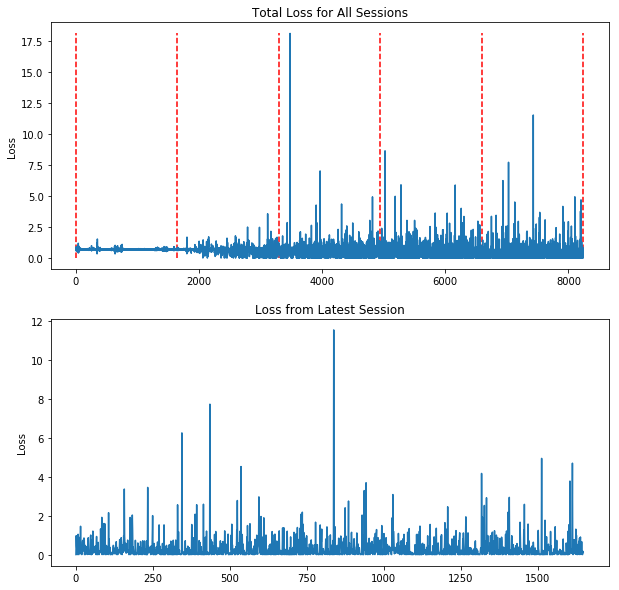

In [6]:
model.fit(epochs=5)
model.plot_loss()

In [31]:
model.predict()
model.performance_metrics()

In [32]:
model.accuracy

{'train': 0.8604368932038835,
 'validate': 0.7049180327868853,
 'test': 0.7114337568058077}

In [25]:
model.confusion_matrix

array([[225.,  27.],
       [121., 178.]])